In [1]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/IndicAccentDB'
!ls $dataset_path


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
andhra_pradesh	gujrat	jharkhand  karnataka  kerala  tamil


In [6]:
import os
import torch
import numpy as np
from tqdm import tqdm
import librosa
from transformers import AutoFeatureExtractor, HubertModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Using device:", device)

# Path to your Drive dataset folder
DATA_PATH = "/content/drive/MyDrive/IndicAccentDB"
SAVE_PATH = "/content/drive/MyDrive"

# Load HuBERT base model
extractor = AutoFeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device)
hubert.eval()

features, labels = [], []
states = sorted(os.listdir(DATA_PATH))

for label, state in enumerate(states):
    folder = os.path.join(DATA_PATH, state)
    wav_files = [f for f in os.listdir(folder) if f.endswith(".wav")]

    for file in tqdm(wav_files[:50], desc=f"Processing {state}"):  # take 50 per state for testing
        try:
            wav_path = os.path.join(folder, file)
            wav, sr = librosa.load(wav_path, sr=16000)

            inputs = extractor(wav, sampling_rate=16000, return_tensors="pt", padding=True).to(device)
            with torch.no_grad():
                outputs = hubert(**inputs)
                emb = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

            features.append(emb)
            labels.append(label)
        except Exception as e:
            print(f"⚠️ Error with {file}: {e}")
            continue

np.save(f"{SAVE_PATH}/hubert_features.npy", np.array(features))
np.save(f"{SAVE_PATH}/hubert_labels.npy", np.array(labels))

print("✅ HuBERT feature extraction complete!")
print("Features shape:", np.array(features).shape)
print("Labels shape:", np.array(labels).shape)


✅ Using device: cuda


Processing tamil: 100%|██████████| 50/50 [00:13<00:00,  3.64it/s]

✅ HuBERT feature extraction complete!
Features shape: (300, 768)
Labels shape: (300,)


✅ Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.67      1.00      0.80        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      0.90      0.95        10

    accuracy                           0.92        60
   macro avg       0.94      0.92      0.92        60
weighted avg       0.94      0.92      0.92        60



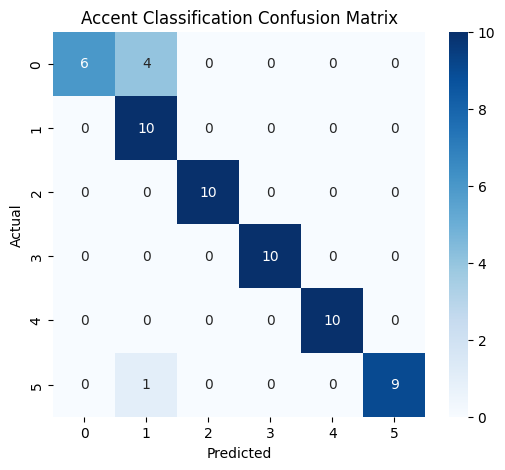

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Load your saved embeddings and labels
X = np.load("/content/drive/MyDrive/hubert_features.npy")
y = np.load("/content/drive/MyDrive/hubert_labels.npy")

# 2️⃣ Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3️⃣ Train a RandomForest classifier

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# 4️⃣ Evaluate
y_pred = model.predict(X_test)
print("✅ Classification Report:\n", classification_report(y_test, y_pred))

# 5️⃣ Confusion matrix visualization
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.title("Accent Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [19]:
import numpy as np
import pandas as pd

X = np.load("/content/drive/MyDrive/hubert_features.npy")
y = np.load("/content/drive/MyDrive/hubert_labels.npy")

# Combine features and labels into one DataFrame
df = pd.DataFrame(X)
df["label"] = y

# Save as CSV
df.to_csv("/content/drive/MyDrive/hubert_features.csv", index=False)
print("✅ Saved as CSV successfully!")


✅ Saved as CSV successfully!


In [20]:
accent_to_cuisine = {
    0: "Andhra Pradesh – Pulihora, Pesarattu",
    1: "Gujarat – Dhokla, Thepla",
    2: "Jharkhand – Litti Chokha",
    3: "Karnataka – Bisi Bele Bath, Neer Dosa",
    4: "Kerala – Appam, Avial, Puttu",
    5: "Tamil Nadu – Pongal, Idli, Dosa"
}

# Take one test example and predict its accent
idx = 0
pred = model.predict([X_test[idx]])[0]

print(f"🎙️ Detected Accent: {states[pred].title()}")
print(f"🍲 Recommended Cuisine: {accent_to_cuisine[pred]}")


🎙️ Detected Accent: Jharkhand
🍲 Recommended Cuisine: Jharkhand – Litti Chokha
